In [69]:
from WassersteinRandomForests import WassersteinRandomForest, WassersteinRandomForest_multi
import matplotlib.pyplot as plt
from seaborn import kdeplot
import numpy as np
from ot import wasserstein_1d
import pickle
from tqdm import tqdm
%matplotlib inline

### Important:

As there is a limit for the size of **Supplementary Material** (100MB), the pretrained models provided in this notebook are not trained with the same parameters of the paper. Hence, the quality of the estimations can not be compared.

## Generate synthetic data

In [2]:
def m(x):
    """
    conditional expectation of Y(0)
    """
    return 10.*x[1]*x[3] + x[2] + np.exp(x[3]-2*x[0]+np.sin(x[1]**3))
def sigma(x):
    """
    conditional variance of Y(0)
    """
    return np.max([-x[0]*x[1]+4.0*x[3]**2, 0.2])
    
def m_1(x):
    return 2.*m(x)- 5.0*x[1]*x[4] + 1.0

def _m_1(x):
    """
    conditional expectation of Y(1)
    """
    return 0.5*m_1(x) - 0.5
    #return 2.*x[4]

def sigma_1(x):
    #return 3.*x[1]*x[3]
    return 3.*x[1]+ x[2]*x[3] + x[5]


def e(x):
    return 0.5*np.sin(2.*x[0]*x[1]+6.*x[2])+0.5


def m_c(x):
    """
    conditional expectation of C(1)
    """
    #return 10.*x[1] + x[2]
    return 2.*x[2]*x[4] + x[1]
def sigma_c(x):
    #return 3.*x[1]*x[3]
    return x[4]*x[5] + 1.

N_total = 10000
N_train = 5000 
def generate_data(dim, N_train = N_train, N_total = N_total):
    X = np.random.uniform(0,1,(N_total,dim))
    Y0 = np.zeros(N_total)
    for i in range(N_total):
        Y0[i] = np.random.normal(m(X[i]),np.sqrt(sigma(X[i])),1) 
    Y1 = np.zeros(N_total)
    for i in range(N_total):
        if np.random.rand()<0.5:
            Y1[i] = np.random.normal(m_1(X[i]),np.sqrt(sigma_1(X[i])),1) 
        else:
            Y1[i] = np.random.normal(-1,1,1) 
            
    Y1C = np.zeros((N_total,2))
    for i in range(N_total):
        Y1C[i][0] = Y1[i]
        Y1C[i][1] = np.random.normal(m_c(X[i]),np.sqrt(sigma_c(X[i])),1)
        
    Y0C = np.zeros((N_total,2))
    for i in range(N_total):
        Y0C[i][0] = Y0[i]
        Y0C[i][1] = np.random.normal(m_c(X[i]),np.sqrt(sigma_c(X[i])),1)
        
    T = np.zeros(N_total,dtype = int)
    for i in range(N_total):
        if np.random.rand()<e(X[i]):
            T[i] =1 
        else:
            T[i] =0 
    return X,Y0,Y1,T,Y1C,Y0C

X,Y0,Y1,T,Y1C,Y0C = generate_data(dim = 50)

# treatment/control splitting
TreatmentIndex = [i for i in range(N_total) if T[i]==1 and i <= N_train] 
ControlIndex = [i for i in range(N_total) if T[i]==0 and i <= N_train] 
testTreatmentIndex = [i for i in range(N_total) if T[i]==1 and i > N_train] 
testControlIndex = [i for i in range(N_total) if T[i]==0 and i > N_train] 

## Training

In [3]:
a_n = 1000 
M = 200
mtry = 45
nodesize = 5

# univariate
reg_inter_0 = WassersteinRandomForest(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = mtry,
                                      #n_jobs = 1,
                                      p = 1,
                                      interpretation = 'inter')
reg_inter_1 = WassersteinRandomForest(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = 10 ,
                                      #n_jobs = 1,
                                      p = 1,
                                      interpretation = 'inter')
reg_intra_0 = WassersteinRandomForest(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = mtry,
                                      #n_jobs = 1,
                                      p = 1,
                                      interpretation = 'inter')
reg_intra_1 = WassersteinRandomForest(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = 10 ,
                                      #n_jobs = 1,
                                      p = 1,
                                      interpretation = 'inter')
# training
reg_inter_0.fit(X[ControlIndex],Y0[ControlIndex])
reg_inter_1.fit(X[TreatmentIndex],Y1[TreatmentIndex])
reg_intra_0.fit(X[ControlIndex],Y0[ControlIndex])
reg_intra_1.fit(X[TreatmentIndex],Y1[TreatmentIndex])

#multivariate
reg_multi = WassersteinRandomForest_multi(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = 45,
                                      #n_jobs = 1,
                                      )

# training
reg_multi.fit(X[TreatmentIndex],Y1C[TreatmentIndex])

100%|██████████| 200/200 [12:19<00:00,  3.70s/it]


In [60]:
#multivariate
reg_multi = WassersteinRandomForest_multi(nodesize = nodesize,
                                      bootstrap = True,
                                      subsample = a_n,
                                      n_estimators = M,
                                      mtry = 45,
                                      #n_jobs = 1,
                                      )

# training
reg_multi.fit(X[TreatmentIndex],Y1C[TreatmentIndex])

100%|██████████| 200/200 [12:39<00:00,  3.80s/it]


In [71]:
# # save models
# with open("models/intra_0_p2.pkl", 'wb') as file:
#     pickle.dump(reg_intra_0, file)
# with open("models/intra_1_p2.pkl", 'wb') as file:
#     pickle.dump(reg_intra_1, file)
# with open("models/inter_0_p1.pkl", 'wb') as file:
#     pickle.dump(reg_inter_0, file)
# with open("models/inter_1_p1.pkl", 'wb') as file:
#     pickle.dump(reg_inter_1, file)
# with open("models/multi.pkl", 'wb') as file:
#     pickle.dump(reg_multi, file)

In [72]:
# load models
with open("models/inter_0_p1.pkl", 'rb') as file:
    reg_inter_0 = pickle.load(file)
with open("models/inter_1_p1.pkl", 'rb') as file:
    reg_inter_1 = pickle.load(file)
with open("models/intra_0_p2.pkl", 'rb') as file:
    reg_intra_0 = pickle.load(file)
with open("models/intra_1_p2.pkl", 'rb') as file:
    reg_intra_1 = pickle.load(file)
with open("models/multi.pkl", 'rb') as file:
    reg_multi = pickle.load(file)

## Utils

In [73]:
def viz_simple(x_individual,_Y,_W, group):
    if group == "control":
        Y= Y0
        ref_sample = np.zeros(5000)
        for i in range(5000):
            ref_sample[i] = np.random.normal(m(x_individual),np.sqrt(sigma(x_individual)),1)
        
    elif group == "treatment":
        Y= Y1
        ref_sample = np.zeros(5000)
        for i in range(5000):
            if np.random.rand()<0.5:
                ref_sample[i] = np.random.normal(m_1(x_individual),np.sqrt(sigma_1(x_individual)),1) 
            else:
                ref_sample[i] = np.random.normal(-1,1,1)
    plt.xlim([-8,20])
    kdeplot(np.random.choice(a = _Y,p = _W,size = 1000), label="kde-pred", color = "black")
    plt.hist(_Y,weights=_W, bins = 20, color = "grey", density = True,alpha = 0.5, label="pred")
    
    plt.hist(ref_sample, density = True, color = "darkred",alpha = 0.3, bins = 20, label="ref")
    kdeplot(ref_sample, label = "kde-ref", color = "darkred")
    kdeplot(Y, label="kde-Y", color = "darkorange")
    plt.grid(linestyle = "dotted",color="black")
    #plt.legend()  

def viz_info(x_individual,method):
    if method =='intra':
        reg_0 = reg_intra_0
        reg_1 = reg_intra_1
    elif method =='inter':
        reg_0 = reg_inter_0
        reg_1 = reg_inter_1
        
    ref_sample0 = np.zeros(5000)
    for i in range(5000):
        ref_sample0[i] = np.random.normal(m(x_individual),np.sqrt(sigma(x_individual)),1)
    ref_sample1 = np.zeros(5000)
    for i in range(5000):
        if np.random.rand()<0.5:
            ref_sample1[i] = np.random.normal(m_1(x_individual),np.sqrt(sigma_1(x_individual)),1) 
        else:
            ref_sample1[i] = np.random.normal(-1,1,1)
    _Y0,_W0 = reg_0.predict_distribution(x_individual)
    _Y1,_W1 = reg_1.predict_distribution(x_individual)
    print(method)
    print("CATE(ref): "+str(_m_1(x_individual) - m(x_individual)))
    print("CATE(pred): "+str(reg_1.predict(x_individual.reshape(1,50)) - reg_0.predict(x_individual.reshape(1,50))))
    print("LAMBDA_1: " + str(wasserstein_1d(ref_sample0,ref_sample1,p=1)))
    print("predLAMBDA_1: " + str(wasserstein_1d(x_a=_Y0,a=_W0,x_b=_Y1,b=_W1,p=1)))
    print("LAMBDA_2: " + str(wasserstein_1d(ref_sample0,ref_sample1,p=2)))
    print("predLAMBDA_2: " + str(wasserstein_1d(x_a=_Y0,a=_W0,x_b=_Y1,b=_W1,p=2)))
    print("W1-loss for Y(0): " + str(wasserstein_1d(np.random.choice(a = _Y0,p = _W0,size = 5000),ref_sample0,p=1)))
    print("W1-loss for Y(1): " + str(wasserstein_1d(np.random.choice(a = _Y1,p = _W1,size = 5000),ref_sample1,p=1)))
    print("W2-loss for Y(0): " + str(wasserstein_1d(np.random.choice(a = _Y0,p = _W0,size = 5000),ref_sample0,p=2)))
    print("W2-loss for Y(1): " + str(wasserstein_1d(np.random.choice(a = _Y1,p = _W1,size = 5000),ref_sample1,p=2)))
    #print("W1-loss for Y(0): " + str(wasserstein_1d(x_a=_Y0,a=_W0,x_b=ref_sample0,p=1)))
    #print("W1-loss for Y(1): " + str(wasserstein_1d(x_a=_Y1,a=_W0,x_b=ref_sample1,p=1)))
    #print("W2-loss for Y(0): " + str(wasserstein_1d(x_a=_Y0,a=_W0,x_b=ref_sample0,p=2)))
    #print("W2-loss for Y(1): " + str(wasserstein_1d(x_a=_Y1,a=_W0,x_b=ref_sample1,p=2)))
    return _Y0,_W0,_Y1,_W1


def viz_multi(x_individual,reg_multi):
    _Y,_W = reg_multi.predict_distribution(x_individual)
    n_sim = 5000
    _Y_plot = _Y[np.random.choice(range(len(_Y)),n_sim, p = _W,replace = True)]
    
    # reference value
    Y_plot = np.zeros((n_sim,2))
    for i in range(n_sim):
        if np.random.rand()<0.5:
            Y_plot[i,0] = np.random.normal(m_1(x_individual),np.sqrt(sigma_1(x_individual)),1)
            Y_plot[i,1] = np.random.normal(m_c(x_individual),np.sqrt(sigma_c(x_individual)),1)
        else:
            #Y[i] = np.random.normal(obj_func(X[i]),np.sqrt(obj_func2(X[i])),1) 
            # Y[i] = np.random.normal(-0.05*obj_func2(X[i]),1,1) 
            #Y[i] = np.random.normal(-1.5*obj_func2(X[i]),1,1) 
            #Y[i] = np.random.normal(obj_func3(X[i]),1,1) 
            
            Y_plot[i,0] = np.random.normal(-1,1,1) 
            Y_plot[i,1] = np.random.normal(m_c(x_individual),np.sqrt(sigma_c(x_individual)),1)
       
    
    kdeplot(_Y_plot[:,0],_Y_plot[:,1],color = "grey", shade=True, shade_lowest=False, label = 'pred', alpha = 1.);
    kdeplot(Y_plot[:,0],Y_plot[:,1],color='darkred', shade=True, shade_lowest=False,label = "ref", alpha = 0.4);
    #ax = sns.jointplot(Y_plot[:,0], Y_plot[:,1],kind = "kde",color = "darkred", shade=True, shade_lowest=False, label = 'a');
    plt.grid(ls = "dotted",color='black')
    plt.xlim([-8,20])
    plt.xlabel("$Y(1)$")
    plt.ylabel("$C(1)$")
    plt.legend()
def evaluate_AWD(reg, group, p = 2, X = X, Y0=Y0, Y1=Y1, N_train = N_train):
    predlist = []
    predlistY = []
    #ideallist = []
    if group == "control":
        for i in tqdm(range(5000)):
            Y_c,W_c = reg.predict_distribution(X[N_train+i])
            predlist +=[wasserstein_1d(p = p,x_a = np.random.choice(Y_c,p=W_c,size = N_train),x_b =np.random.normal(m(X[N_train+i]),sigma(X[N_train+i]),10000))]
            predlistY +=[wasserstein_1d(p = p,x_a = Y0[:N_train],x_b =np.random.normal(m(X[N_train+i]),np.sqrt(sigma(X[N_train+i])),10000))]
    elif group == "treatment":
        for i in tqdm(range(5000)):
            Y_c,W_c = reg.predict_distribution(X[N_train+i])
            _Y1 = np.zeros(10000)
            for j in range(10000):
                if np.random.rand()<0.5:
                    _Y1[j] = np.random.normal(m_1(X[N_train+i]),np.sqrt(sigma_1(X[N_train+i])),1) 
                else:
                    _Y1[j] = np.random.normal(-1,1,1) 
            predlist +=[wasserstein_1d(p = p,x_a = np.random.choice(Y_c,p=W_c,size = N_train),x_b =_Y1)]
            predlistY +=[wasserstein_1d(p = p,x_a = Y1[:N_train],x_b =_Y1)]
    
            
    print("average W"+str(p)+" distance:", np.mean(predlist))
    print("average W"+str(p)+" distance with Y (i.e., no estimation is made):", np.mean(predlistY))

## Reproduce Figure 2

In [74]:
with open("models/bimodal_individual.npy",'rb') as file:
    x_bimodal = np.load("models/bimodal_individual.npy")


inter
CATE(ref): 0.0
CATE(pred): [-1.15761893]
LAMBDA_1: 3.072974346309109
predLAMBDA_1: 2.6710434488508845
LAMBDA_2: 3.218972585832084
predLAMBDA_2: 3.0484987273332504
W1-loss for Y(0): 0.3226627893620772
W1-loss for Y(1): 1.0775518717969412
W2-loss for Y(0): 0.4478107068790342
W2-loss for Y(1): 1.6850224172321222
intra
CATE(ref): 0.0
CATE(pred): [-0.37187777]
LAMBDA_1: 3.082635382942483
predLAMBDA_1: 2.6914089808104507
LAMBDA_2: 3.2308217651098903
predLAMBDA_2: 3.1413678064882076
W1-loss for Y(0): 0.20645310618957538
W1-loss for Y(1): 0.7238828870205548
W2-loss for Y(0): 0.3025942832271847
W2-loss for Y(1): 1.124540368230101


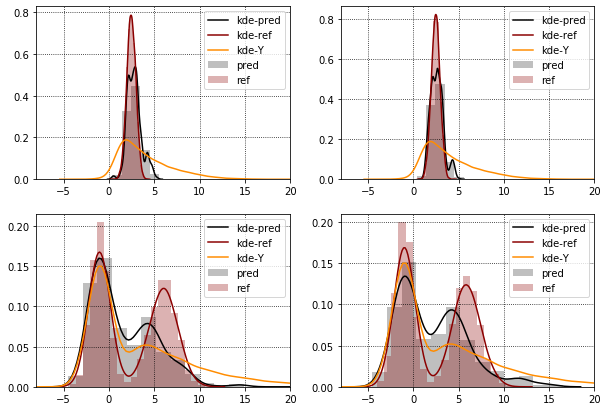

In [75]:
Y0_inter,W0_inter,Y1_inter,W1_inter = viz_info(x_bimodal,method="inter")
Y0_intra,W0_intra,Y1_intra,W1_intra = viz_info(x_bimodal,method="intra")
plt.figure(figsize =(10,7))
plt.subplot(221)
viz_simple(x_bimodal,Y0_inter,W0_inter,"control")
plt.subplot(222)
viz_simple(x_bimodal,Y0_intra,W0_intra,"control")
plt.subplot(223)
viz_simple(x_bimodal,Y1_inter,W1_inter,"treatment")
plt.subplot(224)
viz_simple(x_bimodal,Y1_intra,W1_intra,"treatment")

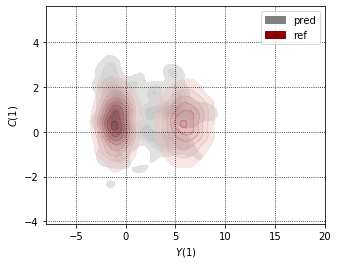

In [76]:
plt.figure(figsize = (5,4))
viz_multi(x_bimodal,reg_multi)

## Reproduce Tabel 1

In [70]:
print("inter_0:")
evaluate_AWD(reg_inter_0,"control", p=1)
print("inter_1:")
evaluate_AWD(reg_inter_1,"treatment", p=1)
print("intra_0:")
evaluate_AWD(reg_intra_0,"control", p=1)
print("intra_1:")
evaluate_AWD(reg_intra_1,"treatment", p=1)

print("inter_0:")
evaluate_AWD(reg_inter_0,"control", p=2)
print("inter_1:")
evaluate_AWD(reg_inter_1,"treatment", p=2)
print("intra_0:")
evaluate_AWD(reg_intra_0,"control", p=2)
print("intra_1:")
evaluate_AWD(reg_intra_1,"treatment", p=2)

  0%|          | 10/5000 [00:00<00:51, 97.34it/s]

inter_0:


  0%|          | 1/5000 [00:00<09:42,  8.57it/s]

average W1 distance: 0.6070849476026563
average W1 distance with Y (i.e., no estimation is made): 2.5303234698704693
inter_1:


  0%|          | 10/5000 [00:00<00:50, 98.70it/s]

average W1 distance: 1.5166644238276745
average W1 distance with Y (i.e., no estimation is made): 2.337375469939217
intra_0:


  0%|          | 1/5000 [00:00<09:14,  9.01it/s]

average W1 distance: 0.6015880220796165
average W1 distance with Y (i.e., no estimation is made): 2.5303718308731833
intra_1:


  0%|          | 13/5000 [00:00<00:40, 123.34it/s]

average W1 distance: 1.5546415622846732
average W1 distance with Y (i.e., no estimation is made): 2.335007525056115
inter_0:


  0%|          | 0/5000 [00:00<?, ?it/s]

average W2 distance: 0.7500689242938159
average W2 distance with Y (i.e., no estimation is made): 3.0869706412559856
inter_1:


  0%|          | 13/5000 [00:00<00:40, 123.65it/s]

average W2 distance: 2.5019343421618725
average W2 distance with Y (i.e., no estimation is made): 3.972786064677837
intra_0:


  0%|          | 1/5000 [00:00<08:56,  9.33it/s]

average W2 distance: 0.7427702466488795
average W2 distance with Y (i.e., no estimation is made): 3.0874160050931736
intra_1:


100%|██████████| 5000/5000 [08:54<00:00,  9.36it/s]

average W2 distance: 2.583684679909839
average W2 distance with Y (i.e., no estimation is made): 3.9721715264302984
